# Textkomplexität

In [3]:
import pandas as pd
from pathlib import Path

In [2]:
# https://pypi.org/project/readability/
import readability

In [ ]:
# https://pypi.org/project/textstat/
import textstat
textstat.set_lang("de")

### Read corpus and compute score

In [28]:
text_dir = Path("../data/txt/")

In [5]:
corpus_texts = {}
for fp in text_dir.iterdir():
    corpus_texts[fp.name] = fp.read_text()

In [46]:
# flesch score only (with textstat)
corpus = {"filename":[], "flesch_score": []}
for fp in text_dir.iterdir():
    corpus["filename"].append(fp.name)
    corpus["flesch_score"].append(textstat.flesch_reading_ease(fp.read_text()))

In [17]:
# all scores in readability 
corpus = {"filename":[]}
for fp in text_dir.iterdir():
    corpus["filename"].append(fp.name)
    result = readability.getmeasures(fp.read_text(), lang='de')
    for measure, score in result['readability grades'].items():
        if measure not in corpus:
            corpus[measure] = []
        corpus[measure].append(score)

In [ ]:
corpus_df = pd.DataFrame(corpus)

### Read metadata

In [20]:
metadata_df = pd.read_csv("../data/metadata.csv", sep=",")

In [36]:
# get overview
metadata_df.groupby(pd.PeriodIndex(metadata_df['date'], freq="Y")).describe()

id                                                          \
        count          mean           std      min       25%      50%   
date                                                                    
1993      1.0   8819.000000           NaN   8819.0   8819.00   8819.0   
1995      2.0   8817.500000      0.707107   8817.0   8817.25   8817.5   
1996      1.0   8816.000000           NaN   8816.0   8816.00   8816.0   
1997      1.0   8815.000000           NaN   8815.0   8815.00   8815.0   
1998      1.0   8814.000000           NaN   8814.0   8814.00   8814.0   
2000      3.0   8812.000000      1.000000   8811.0   8811.50   8812.0   
2001      1.0   8810.000000           NaN   8810.0   8810.00   8810.0   
2004      1.0   8809.000000           NaN   8809.0   8809.00   8809.0   
2005      2.0   8807.500000      0.707107   8807.0   8807.25   8807.5   
2006      3.0   8805.000000      1.000000   8804.0   8804.50   8805.0   
2008      3.0   8802.000000      1.000000   8801.0   8801.50   8802.0   
2009      3.0   8799.000000      1.000000   8798.0   8798.50   8799.0   
2010      3.0   8796.000000      1.000000   8795.0   8795.50   8796.0   
2011   1122.0   8233.500000    324.037806   7673.0   7953.25   8233.5   
2012   1234.0   7055.500000    356.369424   6439.0   6747.25   7055.5   
2013   1263.0   5807.000000    364.741004   5176.0   5491.50   5807.0   
2014   1056.0   4647.500000    304.985246   4120.0   4383.75   4647.5   
2015   1060.0   3589.464151    306.201723   3056.0   3324.75   3589.5   
2016    900.0   2609.056667    260.458512   2159.0   2383.75   2609.5   
2017   1144.0   1585.691434    330.892949   1011.0   1299.75   1585.5   
2018   3314.0    635.798733    354.373869      0.0    348.25    624.5   
2019   8016.0  13364.438872  19090.689980      0.0   1786.75   3791.5   
2020   9720.0  42031.910905   2834.449710   2290.0  39605.75  42035.5   
2021  10142.0  24299.328732   6083.288165    746.0  20000.25  22535.5   
2022   9860.0  12535.500000   2846.481161   7606.0  10070.75  12535.5   
2023   9883.0  10798.348072  12934.845424      0.0   2470.50   4941.0   
2024   7293.0  29382.000000   2105.452089  25736.0  27559.00  29382.0   

                         
           75%      max  
date                     
1993   8819.00   8819.0  
1995   8817.75   8818.0  
1996   8816.00   8816.0  
1997   8815.00   8815.0  
1998   8814.00   8814.0  
2000   8812.50   8813.0  
2001   8810.00   8810.0  
2004   8809.00   8809.0  
2005   8807.75   8808.0  
2006   8805.50   8806.0  
2008   8802.50   8803.0  
2009   8799.50   8800.0  
2010   8796.50   8797.0  
2011   8513.75   8794.0  
2012   7363.75   7672.0  
2013   6122.50   6438.0  
2014   4911.25   5175.0  
2015   3854.25   4119.0  
2016   2834.25   3069.0  
2017   1872.25   2158.0  
2018    901.00   1439.0  
2019   5795.25  48767.0  
2020  44465.25  46895.0  
2021  25070.75  37176.0  
2022  15000.25  17465.0  
2023   7411.50  35305.0  
2024  31205.00  33028.0

In [21]:
metadata_df = metadata_df.merge(corpus_df)

In [24]:
metadata_df.head()

,id,url,date,title,filename,Kincaid,ARI,Coleman-Liau,FleschReadingEase,GunningFogIndex,LIX,SMOGIndex,RIX,DaleChallIndex
0,5849,https://www.berlin.de/ba-spandau/aktuelles/pre...,2023-03-10,Die Spandauer Jugendjury geht in die nächste R...,2023-03-10_id5849.txt,36.690256,45.679038,18.910521,-29.061923,35.046154,115.179487,18.000000,29.0,14.084467
1,37162,https://www.berlin.de/polizei/polizeimeldungen...,2021-01-03,Mann vermutlich mit Messer verletzt,2021-01-03_id37162.txt,33.162482,41.613885,19.094887,-18.908939,32.979856,105.471223,19.431677,25.0,13.217945
2,7720,https://www.berlin.de/ba-marzahn-hellersdorf/a...,2011-12-13,Bezirk beschreitet neue Wege zur Realisierung ...,2011-12-13_id7720.txt,75.242045,95.097614,19.644275,-130.910682,75.172727,210.375000,28.099801,60.5,18.242492
3,5931,https://www.berlin.de/ba-marzahn-hellersdorf/a...,2013-05-21,Auch im Bienengarten wird am 01. Juni Kinderta...,2013-05-21_id5931.txt,26.720243,32.259903,18.504190,-4.781189,23.318447,86.451456,13.246951,18.0,13.549347
4,2679,https://www.berlin.de/ba-marzahn-hellersdorf/a...,2016-05-30,Offene Kirche am Sonntag,2016-05-30_id2679.txt,54.195612,68.137673,19.308771,-75.307398,51.938776,155.561224,19.431677,40.5,16.221847


In [ ]:
metadata_df.to_csv("metadata_with_scores.csv", index=False)

### Analyse

In [25]:
metadata_df['date'] = pd.to_datetime(metadata_df['date'])

<Axes: xlabel='date'>

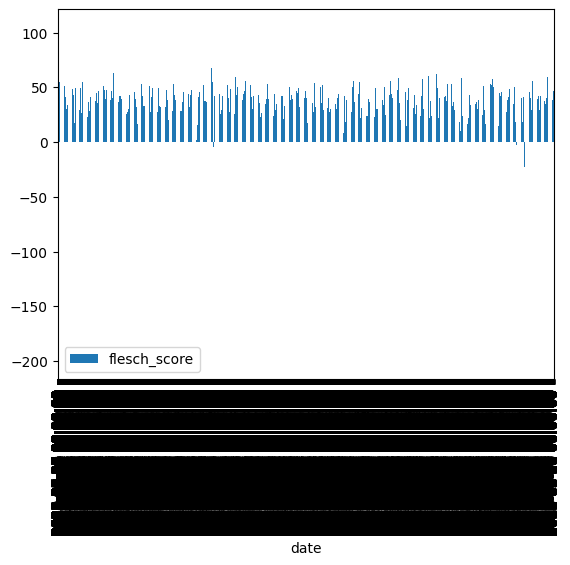

In [28]:
# with textstat scores
metadata_df.plot(x="date", y="flesch_score", kind="bar")

<Axes: xlabel='date'>

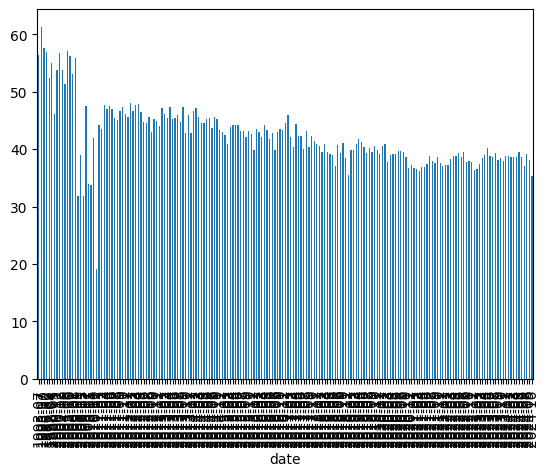

In [29]:
metadata_df.groupby(pd.PeriodIndex(metadata_df['date'], freq="M"))['flesch_score'].mean().plot(kind="bar")

<Axes: xlabel='date'>

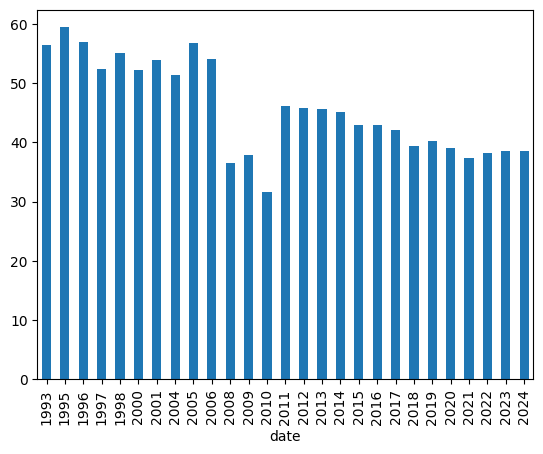

In [30]:
metadata_df.groupby(pd.PeriodIndex(metadata_df['date'], freq="Y"))['flesch_score'].mean().plot(kind="bar")

<Axes: xlabel='date'>

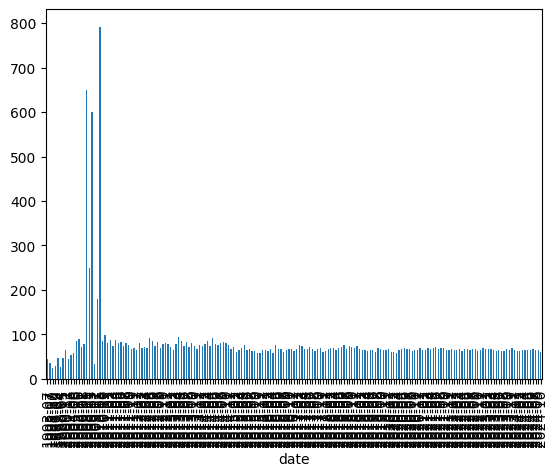

In [27]:
metadata_df.groupby(pd.PeriodIndex(metadata_df['date'], freq="M"))['ARI'].mean().plot(kind="bar")

### Was "Leichte Sprache" discussed at some point?

In [39]:
mentions_simplified = []
for fp, text in corpus_texts.items():
    if "leichte Sprache" in text:
        mentions_simplified.append(fp)

In [40]:
len(mentions_simplified)

4

In [41]:
mentions_simplified

['2018-10-02_id873.txt',
 '2021-05-28_id23791.txt',
 '2020-06-03_id42694.txt',
 '2019-02-01_id5490.txt']

In [42]:
corpus_texts['2018-10-02_id873.txt']

'Mitte präsentiert sich jetzt auch online barrierefrei – Webauftritt des Bezirksamts in leichter Sprache\nDer Bezirksbürgermeister von Mitte, Stephan von Dassel, informiert: Nach den Bezirken Friedrichshain-Kreuzberg, Treptow-Köpenick und Neukölln bietet nun auch das Bezirksamt Mitte seinen Webauftritt zusätzlich in leichter Sprache an. Damit wird die Internetpräsenz des Bezirksamtes für eine weitere große Gruppe von Menschen leichter und einfacher nutzbar. Hierzu zählen Menschen mit kognitiven Beeinträchtigungen, funktionale Analphabetinnen und Analphabeten, aber auch Menschen, die aus unterschiedlichen Gründen über eine geringe Kompetenz in der deutschen Sprache verfügen. „Mit dem Angebot in leichter Sprache sind wir wieder einen Schritt weiter in unserem Bemühen, als Bezirksamt für alle Menschen da zu sein. Wir wollen, dass jede Bürgerin und jeder Bürger in Mitte aktiv und möglichst selbstständig am gesellschaftlichen Leben teilhaben kann. Unsere Webseiten in leichter Sprache leiste